In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import folktables
from folktables import ACSDataSource, ACSEmployment, generate_categories, ACSIncome, ACSHealthInsurance
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.regressionplots import abline_plot
from statsmodels.formula.api import ols
from scipy.stats import linregress
import math
import sklearn
from sklearn.metrics import mean_squared_error
import statistics
import numpy as np
import seaborn as sns

In [2]:
ACSIncome_categories = {
    "COW": {
        1.0: (
            "Employee of a private for-profit company or"
            "business, or of an individual, for wages,"
            "salary, or commissions"
        ),
        2.0: (
            "Employee of a private not-for-profit, tax-exempt,"
            "or charitable organization"
        ), 
        3.0: "Local government employee (city, county, etc.)",
        4.0: "State government employee",
        5.0: "Federal government employee", 
        6.0: (
            "Self-employed in own not incorporated business,"
            "professional practice, or farm"
        ),
        7.0: (
            "Self-employed in own incorporated business,"
            "professional practice or farm"
        ),
        8.0: "Working without pay in family business or farm",
        9.0: "Unemployed and last worked 5 years ago or earlier or never worked",
    },
    "SCHL": {
        1.0: "No schooling completed",
        2.0: "Nursery school, preschool",
        3.0: "Kindergarten",
        4.0: "Grade 1",
        5.0: "Grade 2",
        6.0: "Grade 3",
        7.0: "Grade 4",
        8.0: "Grade 5",
        9.0: "Grade 6",
        10.0: "Grade 7",
        11.0: "Grade 8",
        12.0: "Grade 9",
        13.0: "Grade 10",
        14.0: "Grade 11",
        15.0: "12th grade - no diploma",
        16.0: "Regular high school diploma",
        17.0: "GED or alternative credential",
        18.0: "Some college, but less than 1 year",
        19.0: "1 or more years of college credit, no degree",
        20.0: "Associate's degree",
        21.0: "Bachelor's degree",
        22.0: "Master's degree",
        23.0: "Professional degree beyond a bachelor's degree",
        24.0: "Doctorate degree",
    },
    "MAR": {
        1.0: "Married",
        2.0: "Widowed",
        3.0: "Divorced",
        4.0: "Separated",
        5.0: "Never married or under 15 years old",
    },
    "SEX": {1.0: "Male", 2.0: "Female"},
    "RAC1P": {
        1.0: "White alone",
        2.0: "Black or African American alone",
        3.0: "American Indian alone",
        4.0: "Alaska Native alone",
        5.0: (
            "American Indian and Alaska Native tribes specified;"
            "or American Indian or Alaska Native,"
            "not specified and no other"
        ),
        6.0: "Asian alone",
        7.0: "Native Hawaiian and Other Pacific Islander alone",
        8.0: "Some Other Race alone",
        9.0: "Two or More Races",
    },
}

## Plotting

In [3]:
#edited to include WAGP and disclude RELP and POBP
ACSIncome = folktables.BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'WKHP',
        'SEX',
        'RAC1P',
        'WAGP',
        'HISP'
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,    
    group='RAC1P',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

In [4]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
ca_data = data_source.get_data(states=["CA"], download=True)

ca_features1, ca_labels1, _ = ACSIncome.df_to_pandas(ca_data, categories=ACSIncome_categories, dummies=False)


In [5]:
ca_features1

,AGEP,COW,SCHL,MAR,OCCP,WKHP,SEX,RAC1P,WAGP,HISP
0,30,Self-employed in own not incorporated business...,Grade 11,Married,9610.0,40.0,Male,Some Other Race alone,500.0,2
1,21,State government employee,Regular high school diploma,Never married or under 15 years old,1970.0,20.0,Male,White alone,7700.0,1
2,65,"Employee of a private not-for-profit, tax-exem...",Master's degree,Never married or under 15 years old,2040.0,8.0,Male,White alone,5000.0,1
3,33,Employee of a private for-profit company orbus...,Grade 11,Divorced,9610.0,40.0,Male,White alone,12000.0,1
4,18,"Employee of a private not-for-profit, tax-exem...","1 or more years of college credit, no degree",Never married or under 15 years old,1021.0,18.0,Female,White alone,300.0,7
...,...,...,...,...,...,...,...,...,...,...
195660,38,Employee of a private for-profit company orbus...,Master's degree,Married,1021.0,40.0,Male,Asian alone,565000.0,1
195661,39,Employee of a private for-profit company orbus...,Master's degree,Married,1021.0,40.0,Female,Asian alone,209000.0,1
195662,61,Employee of a private for-profit company orbus...,"1 or more years of college credit, no degree",Married,5240.0,45.0,Male,White alone,105000.0,1
195663,69,"Self-employed in own incorporated business,pro...",Doctorate degree,Married,2040.0,45.0,Male,Asian alone,30000.0,1


In [6]:
asian=ca_features1[ca_features1['RAC1P']=='Asian alone']
black=ca_features1[ca_features1['RAC1P']=='Black or African American alone']
white=ca_features1[ca_features1['RAC1P']=='White alone']
hisp=ca_features1[ca_features1['RAC1P']=='Some Other Race alone']
plottable=pd.concat([asian, black, white, hisp])
plottable['AGEP'] = plottable['AGEP'].astype(int) #changing strings with numbers to integers
plottable['OCCP'] = plottable['OCCP'].astype(int)
plottable['WKHP'] = plottable['WKHP'].astype(int)
plottable['WAGP'] = plottable['WAGP'].astype(int)
plottable['HISP'] = plottable['HISP'].astype(int)
plottable["MAR"].replace({"Never married or under 15 years old": "Never married"}, inplace=True)
plottable["RAC1P"].replace({"Asian alone": "Asian"}, inplace=True)
plottable["RAC1P"].replace({"Black or African American alone": "Black"}, inplace=True)
plottable["RAC1P"].replace({"White alone": "White"}, inplace=True)
plottable["RAC1P"].replace({"Some Other Race alone": "Other"}, inplace=True)
plottable=plottable.rename(columns={"AGEP": "AGE", "RAC1P": "RACE", "WAGP": "SALARY"})
plottable=plottable[plottable['SALARY']<350000]
for i in range(3,25):
    plottable['HISP']=plottable['HISP'].replace(i,2,regex=True)
plottable

,AGE,COW,SCHL,MAR,OCCP,WKHP,SEX,RACE,SALARY,HISP
27,23,"Employee of a private not-for-profit, tax-exem...",Bachelor's degree,Never married,2545,20,Female,Asian,4000,1
33,18,Employee of a private for-profit company orbus...,Regular high school diploma,Never married,9610,8,Female,Asian,1500,1
49,18,Employee of a private for-profit company orbus...,"Some college, but less than 1 year",Never married,725,12,Female,Asian,1400,1
53,25,State government employee,Bachelor's degree,Never married,3870,40,Male,Asian,13000,1
80,20,"Employee of a private not-for-profit, tax-exem...",GED or alternative credential,Never married,725,18,Female,Asian,650,1
...,...,...,...,...,...,...,...,...,...,...
195602,24,Employee of a private for-profit company orbus...,Bachelor's degree,Never married,2300,40,Female,Other,20000,2
195628,46,Employee of a private for-profit company orbus...,GED or alternative credential,Married,8740,40,Female,Other,12000,2
195629,50,Employee of a private for-profit company orbus...,12th grade - no diploma,Married,7340,50,Male,Other,17900,2
195642,42,Employee of a private for-profit company orbus...,Grade 9,Married,6260,40,Male,Other,61000,2


In [13]:
plottable.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,182867.0,42.909169,14.899778,17.0,30.0,42.0,55.0,94.0
OCCP,182867.0,4036.304730,2637.664438,10.0,2016.0,4110.0,5550.0,9830.0
WKHP,182867.0,37.784111,12.926377,1.0,32.0,40.0,40.0,99.0
SALARY,182867.0,50260.777067,52382.233154,0.0,12500.0,35000.0,70000.0,329000.0
HISP,182867.0,1.331192,0.470643,1.0,1.0,1.0,2.0,2.0


Text(0.5, 0, 'Age')

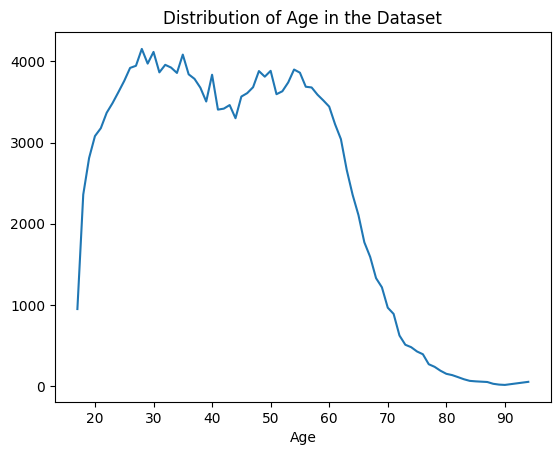

In [37]:
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt 

freq_age=plottable['AGE'].value_counts().sort_index()
freq_age.to_frame()
## x-axis for the plot
x_data = freq_age.index.values
  
## y-axis as the gaussian
y_data = stats.norm.pdf(freq_age)
  
## plot data
plt.plot(freq_age)
plt.title('Distribution of Age in the Dataset')
plt.xlabel('Age')

Text(0.5, 0, 'Age')

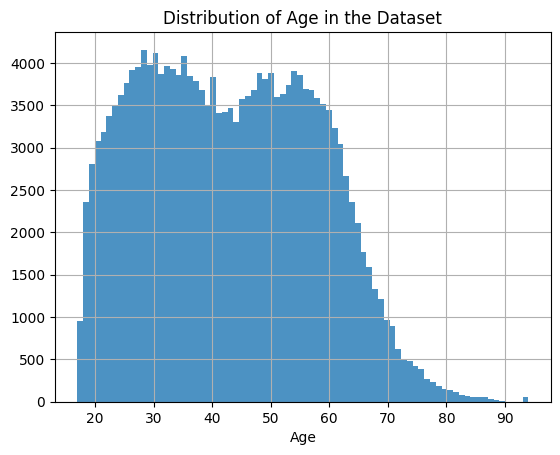

In [19]:
plt.grid()
plt.hist(plottable['AGE'], bins=78, alpha=0.8)
plt.title('Distribution of Age in the Dataset')
plt.xlabel('Age')

Text(0.5, 0, 'Hours Worked per Week')

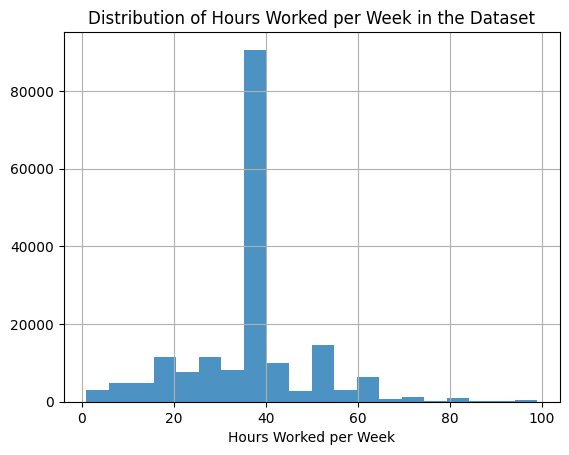

In [29]:
plt.grid()
plt.hist(plottable['WKHP'], bins=20, alpha=0.8)
plt.title('Distribution of Hours Worked per Week in the Dataset')
plt.xlabel('Hours Worked per Week')

Text(0.5, 0, 'Salary')

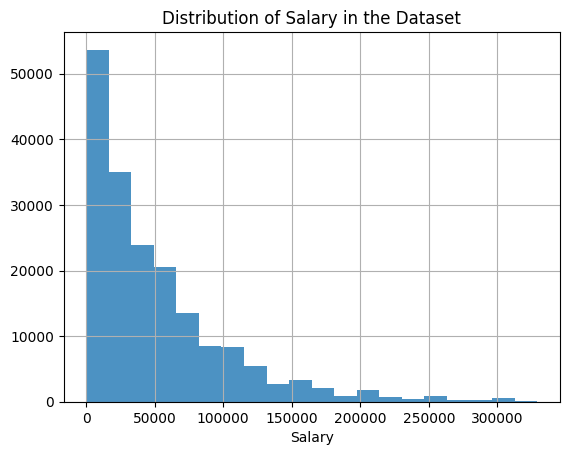

In [25]:
plt.grid()
plt.hist(plottable['SALARY'], bins=20, alpha=0.8)
plt.title('Distribution of Salary in the Dataset')
plt.xlabel('Salary')

<AxesSubplot:title={'center':'SALARY'}, xlabel='RACE'>

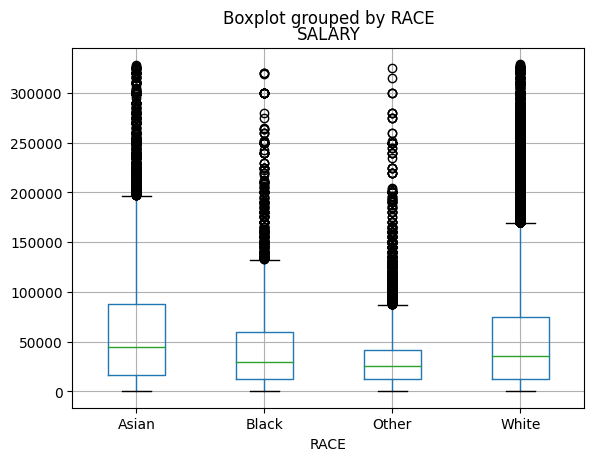

In [31]:
plottable.boxplot(by ='RACE', column =['SALARY'], grid = True)

In [33]:
by_race_gender_mean = plottable.groupby(['RACE','SEX'],as_index=False).SALARY.mean()
by_race_gender_median = plottable.groupby(['RACE','SEX'],as_index=False).SALARY.median()
by_race_gender_mean=by_race_gender_mean.rename(columns={'SALARY':"Mean_Salary"})
by_race_gender_median=by_race_gender_median.rename(columns={'SALARY':"Median_Salary"})
print(by_race_gender_mean,"\n")
print(by_race_gender_median)

    RACE     SEX   Mean_Salary
0  Asian  Female  52864.154185
1  Asian    Male  67356.512708
2  Black  Female  40330.507380
3  Black    Male  44765.347056
4  Other  Female  27031.443645
5  Other    Male  35275.147723
6  White  Female  43438.414165
7  White    Male  59038.678868 

    RACE     SEX  Median_Salary
0  Asian  Female        39000.0
1  Asian    Male        50000.0
2  Black  Female        30000.0
3  Black    Male        31100.0
4  Other  Female        21400.0
5  Other    Male        30000.0
6  White  Female        30000.0
7  White    Male        40900.0


Text(0.5, 1.0, 'Mean Salary by Sex and Race')

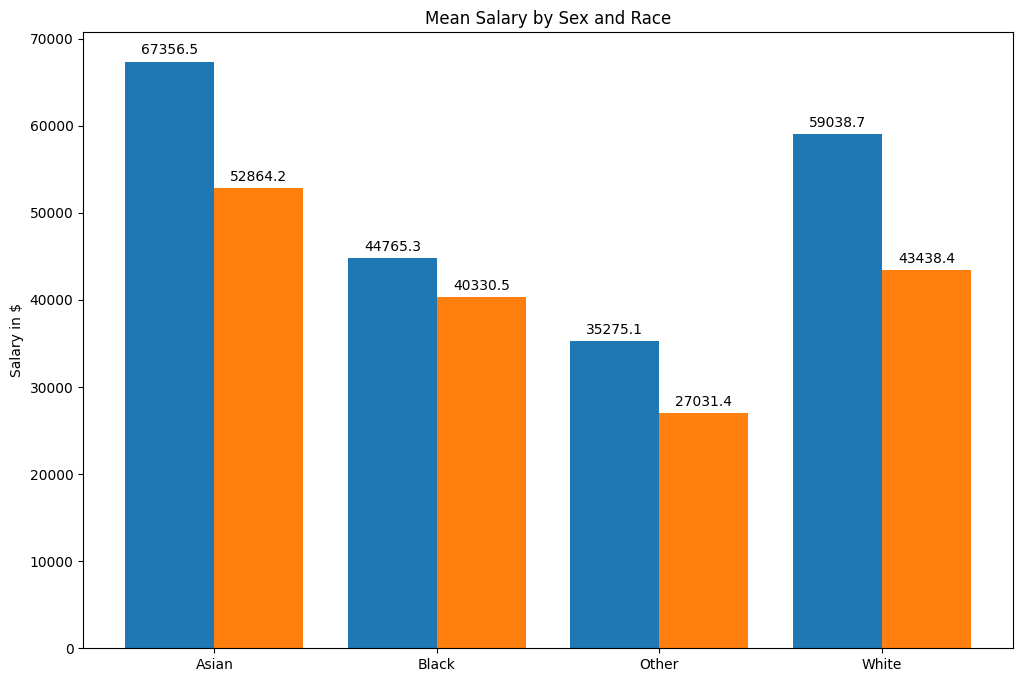

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(by_race_gender_mean.RACE.unique()))

# Define bar width. We'll use this to offset the second bar.

# Note we add the `width` parameter now which sets the width of each bar.
b1 = ax.bar(x, by_race_gender_mean.loc[by_race_gender_mean['SEX'] == 'Male', 'Mean_Salary'], width=0.4, label='Male')
# Same thing, but offset the x by the width of the bar.
b2 = ax.bar(x + 0.4, by_race_gender_mean.loc[by_race_gender_mean['SEX'] == 'Female', 'Mean_Salary'], width=0.4, label='Female')
# Fix the x-axes.
ax.set_xticks(x + 0.2)
ax.set_xticklabels(by_race_gender_mean.RACE.unique())

ax.set_ylabel("Salary in $")
ax.bar_label(b1, padding=3)
ax.bar_label(b2, padding=3)
ax.set_title("Mean Salary by Sex and Race")


Text(0.5, 1.0, 'Median Salary by Sex and Race')

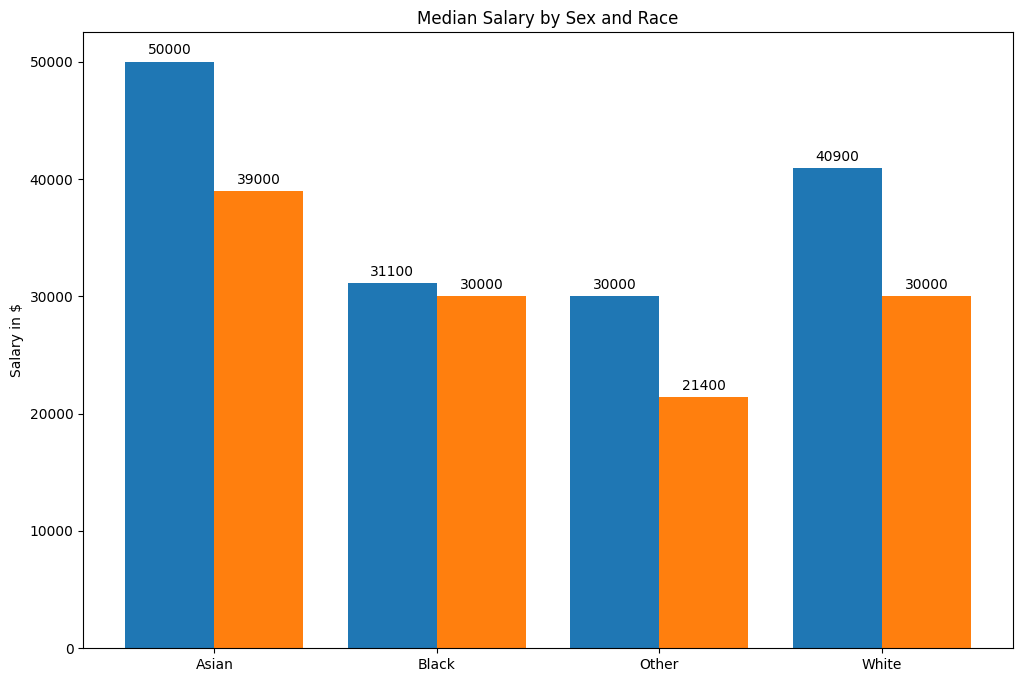

In [35]:
fig, axx = plt.subplots(figsize=(12, 8))
x = np.arange(len(by_race_gender_median.RACE.unique()))

# Define bar width. We'll use this to offset the second bar.
bar_width = 0.4

# Note we add the `width` parameter now which sets the width of each bar.
b1 = axx.bar(x, by_race_gender_median.loc[by_race_gender_median['SEX'] == 'Male', 'Median_Salary'],
            width=bar_width, label='Male')
# Same thing, but offset the x by the width of the bar.
b2 = axx.bar(x + bar_width, by_race_gender_median.loc[by_race_gender_median['SEX'] == 'Female', 'Median_Salary'],
            width=bar_width, label="Female")
# Fix the x-axes.
axx.set_xticks(x + bar_width / 2)
axx.set_xticklabels(by_race_gender_median.RACE.unique())
axx.bar_label(b1, padding=3)
axx.bar_label(b2, padding=3)
axx.set_ylabel("Salary in $")

axx.set_title("Median Salary by Sex and Race")


In [145]:
salary_fit = pd.cut(plottable.SALARY, bins = [0,plottable['SALARY'].median(),350001], labels= [True, False])
plottable.insert(10, 'Salary_below_median', salary_fit)
plottable

ValueError: cannot insert Salary_below_median, already exists

In [39]:
ACSIncome_categories_1 = {
    "COW": {
             (
            "Employee of a private for-profit company or"
            "business, or of an individual, for wages,"
            "salary, or commissions"
        ):1,
             (
            "Employee of a private not-for-profit, tax-exempt,"
            "or charitable organization"
        ):2, 
            "Local government employee (city, county, etc.)":3,
            "State government employee":4,
            "Federal government employee":5, 
             (
            "Self-employed in own not incorporated business,"
            "professional practice, or farm"
        ):6,
             (
            "Self-employed in own incorporated business,"
            "professional practice or farm"
        ):7,
            "Working without pay in family business or farm":8,
            "Unemployed and last worked 5 years ago or earlier or never worked":9,
    }, 
    "SCHL": {"No schooling completed":1,
             "Nursery school, preschool":2,
             "Kindergarten":3,
             "Grade 1":4,
             "Grade 2":5,
             "Grade 3":6, 
             "Grade 4":7,
             "Grade 5":8,
             "Grade 6":9,
             "Grade 7":10,
             "Grade 8":11, 
             "Grade 9":12,
             "Grade 10":13,
             "Grade 11":14,
             "12th grade - no diploma":15,
             "Regular high school diploma":16,
             "GED or alternative credential":17,
             "Some college, but less than 1 year":18,
             "1 or more years of college credit, no degree":19,
             "Associate's degree":20,
             "Bachelor's degree":21,
             "Master's degree":22, 
             "Professional degree beyond a bachelor's degree":23,
             "Doctorate degree":24},
    "MAR": { "Married":1,
             "Widowed":2,
             "Divorced":3,
             "Separated":4,
             "Never married":5},
    "SEX": { "Male":1, 
             "Female":2},
    "RACE": {"White":1,
             "Black":2,
             "Asian":3,
             "Other":4,
    },
}

In [40]:
obj_df = plottable.replace(ACSIncome_categories_1)
obj_df

,AGE,COW,SCHL,MAR,OCCP,WKHP,SEX,RACE,SALARY,HISP,Salary_below_median
27,23,2,21,5,2545,20,2,3,4000,1,True
33,18,1,16,5,9610,8,2,3,1500,1,True
49,18,1,18,5,725,12,2,3,1400,1,True
53,25,4,21,5,3870,40,1,3,13000,1,True
80,20,2,17,5,725,18,2,3,650,1,True
...,...,...,...,...,...,...,...,...,...,...,...
195602,24,1,21,5,2300,40,2,4,20000,2,True
195628,46,1,17,1,8740,40,2,4,12000,2,True
195629,50,1,15,1,7340,50,1,4,17900,2,True
195642,42,1,12,1,6260,40,1,4,61000,2,False


In [41]:
obj_df = obj_df[obj_df['Salary_below_median'].notna()]
#obj_df['Salary_below_median']=obj_df['Salary_below_median'].dropna()
obj_df['Salary_below_median'].isna().sum()


0

In [42]:
import rfpimp
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [44]:
train,test=obj_df.drop(['SALARY','Salary_below_median'],axis=1), obj_df['Salary_below_median']
X_train, X_test, y_train, y_test = train_test_split(train,test, test_size=0.2, random_state=np.random.seed())

### Binary Classifier (non Fair-ML)

In [45]:

model=LinearRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test)

In [47]:
# Linear Regression on Binary Classifier
from sklearn import metrics
print("For the Linear Regression")
print("RMSE: %f" % (metrics.mean_squared_error(y_test,predictions, squared=False)))
print("MSE: %f" % (metrics.mean_squared_error(y_test,predictions, squared=True)))
print("MAE: %f" % (metrics.mean_absolute_error(y_test,predictions)))
print("R2 score: %f" % (metrics.r2_score(y_test,predictions)))

For the Linear Regression
RMSE: 0.404458
MSE: 0.163586
MAE: 0.345404
R2 score: 0.342870


In [62]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
params = {
    "n_estimators": 100,
    "max_depth": 6,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [49]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
xg_pred=reg.predict(X_test)
print("For the XGBoost model")
print("MSE: %f" % (metrics.mean_squared_error(y_test,xg_pred, squared=False)))
print("MAE: %f" % (metrics.mean_absolute_error(y_test,xg_pred)))
print("R2 score: %f" % (metrics.r2_score(y_test,xg_pred)))

For the XGBoost model
MSE: 0.351135
MAE: 0.252289
R2 score: 0.504718


In [65]:
from sklearn.tree import DecisionTreeRegressor
mod =DecisionTreeRegressor()
mod.fit(X_train, y_train)
dtr_pred=mod.predict(X_test)
print("For the Decision Tree model")
print("MSE: %f" % (metrics.mean_squared_error(y_test,dtr_pred, squared=False)))
print("MAE: %f" % (metrics.mean_absolute_error(y_test,dtr_pred)))
print("R2 score: %f" % (metrics.r2_score(y_test,dtr_pred)))

For the XGBoost model
MSE: 0.485295
MAE: 0.239458
R2 score: 0.053943


In [50]:
import rfpimp
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [51]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = np.random.seed())
regressor.fit(X_train, y_train)  
Y_pred = regressor.predict(X_test)

In [52]:
imp = rfpimp.importances(regressor, X_test, y_test)
imp

,Importance
Feature,
WKHP,0.345477
OCCP,0.198873
AGE,0.127415
SCHL,0.061067
SEX,0.030821
MAR,0.021938
COW,0.016531
RACE,0.014996
HISP,0.011757


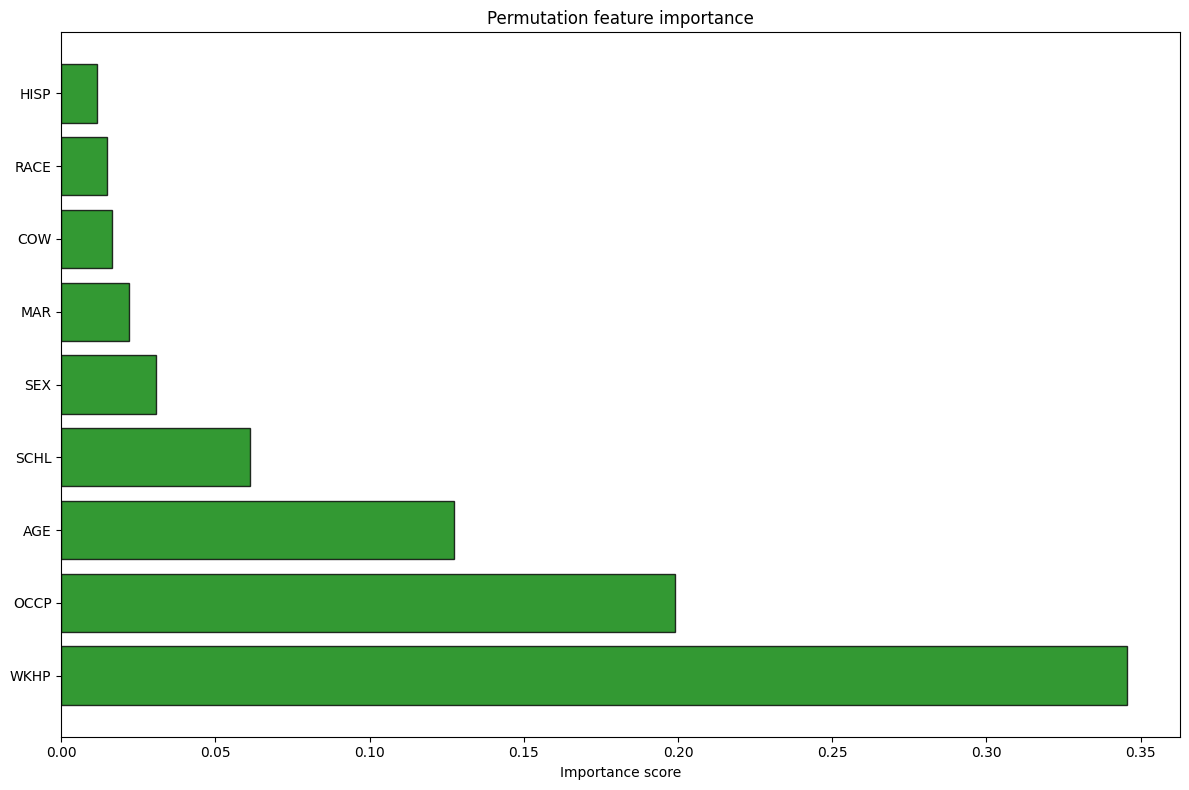

In [53]:
fig1, Axes = plt.subplots(figsize=(12, 8))
Axes.barh(imp.index, imp['Importance'], height=0.8, facecolor='green', alpha=0.8, edgecolor='k')
Axes.set_xlabel('Importance score')
Axes.set_title('Permutation feature importance')


fig1.tight_layout()

In [54]:
print("For the RF model")
print("MSE: %f" % (metrics.mean_squared_error(y_test,Y_pred, squared=False)))
print("MAE: %f" % (metrics.mean_absolute_error(y_test,Y_pred)))
print("R2 score: %f" % (metrics.r2_score(y_test,Y_pred)))

For the RF model
MSE: 0.366318
MAE: 0.246208
R2 score: 0.460959


### Fair ML Attempt

In [55]:
from fairml import audit_model

In [67]:
import dalex as dx
print(dx.__version__)

1.5.0


In [72]:
exp_lin = dx.Explainer(model, X_test, y_test, verbose=False)
exp_xgb = dx.Explainer(reg, X_test, y_test, verbose=False)
exp_rfg = dx.Explainer(regressor, X_test, y_test, verbose=False)
exp_dtr = dx.Explainer(mod, X_test, y_test, verbose=False)

C:\Users\naila\anaconda3\envs\fresh\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\naila\anaconda3\envs\fresh\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names



'float' object has no attribute 'astype'
'float' object has no attribute 'astype'


C:\Users\naila\anaconda3\envs\fresh\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



'float' object has no attribute 'astype'
'float' object has no attribute 'astype'


C:\Users\naila\anaconda3\envs\fresh\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names



In [76]:
exp_lin.model_performance().result.append(exp_xgb.model_performance().result).append(exp_rfg.model_performance().result).append(exp_dtr.model_performance().result)

C:\Users\naila\AppData\Local\Temp\ipykernel_4024\327478243.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\naila\AppData\Local\Temp\ipykernel_4024\327478243.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\naila\AppData\Local\Temp\ipykernel_4024\327478243.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,mse,rmse,r2,mae,mad
LinearRegression,0.163586,0.404458,0.342870,0.345404,0.329162
GradientBoostingRegressor,0.123295,0.351135,0.504718,0.252289,0.164807
RandomForestRegressor,0.134189,0.366318,0.460959,0.246208,0.140000
DecisionTreeRegressor,0.235511,0.485295,0.053943,0.239458,0.000000


#### Direct Density Ratio Estimation

In [ ]:
protected = np.where(X_test.racepctblack >= 0.5, 'majority_black', "else")
privileged = 'else'

# Using One-Hot Encoded Data

In [78]:
ACSIncome_categories = {
    "COW": {
        1.0: (
            "Employee of a private for-profit company or"
            "business, or of an individual, for wages,"
            "salary, or commissions"
        ),
        2.0: (
            "Employee of a private not-for-profit, tax-exempt,"
            "or charitable organization"
        ), 
        3.0: "Local government employee (city, county, etc.)",
        4.0: "State government employee",
        5.0: "Federal government employee", 
        6.0: (
            "Self-employed in own not incorporated business,"
            "professional practice, or farm"
        ),
        7.0: (
            "Self-employed in own incorporated business,"
            "professional practice or farm"
        ),
        8.0: "Working without pay in family business or farm",
        9.0: "Unemployed and last worked 5 years ago or earlier or never worked",
    },
    "SCHL": {
        1.0: "No schooling completed",
        2.0: "Nursery school, preschool",
        3.0: "Kindergarten",
        4.0: "Grade 1",
        5.0: "Grade 2",
        6.0: "Grade 3",
        7.0: "Grade 4",
        8.0: "Grade 5",
        9.0: "Grade 6",
        10.0: "Grade 7",
        11.0: "Grade 8",
        12.0: "Grade 9",
        13.0: "Grade 10",
        14.0: "Grade 11",
        15.0: "12th grade - no diploma",
        16.0: "Regular high school diploma",
        17.0: "GED or alternative credential",
        18.0: "Some college, but less than 1 year",
        19.0: "1 or more years of college credit, no degree",
        20.0: "Associate's degree",
        21.0: "Bachelor's degree",
        22.0: "Master's degree",
        23.0: "Professional degree beyond a bachelor's degree",
        24.0: "Doctorate degree",
    },
    "MAR": {
        1.0: "Married",
        2.0: "Widowed",
        3.0: "Divorced",
        4.0: "Separated",
        5.0: "Never married or under 15 years old",
    },
    "SEX": {1.0: "Male", 2.0: "Female"},
    "RAC1P": {
        1.0: "White alone",
        2.0: "Black or African American alone",
        3.0: "American Indian alone",
        4.0: "Alaska Native alone",
        5.0: (
            "American Indian and Alaska Native tribes specified;"
            "or American Indian or Alaska Native,"
            "not specified and no other"
        ),
        6.0: "Asian alone",
        7.0: "Native Hawaiian and Other Pacific Islander alone",
        8.0: "Some Other Race alone",
        9.0: "Two or More Races",
    },
}

In [79]:
ACSIncome = folktables.BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'WKHP',
        'SEX',
        'RAC1P',
        'WAGP',
        'HISP'
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,    
    group='RAC1P',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

In [77]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
ca_data = data_source.get_data(states=["CA"], download=True)

ca_features, ca_labels, _ = ACSIncome.df_to_pandas(ca_data, categories=ACSIncome_categories, dummies=True)
ca_features

,AGEP,OCCP,WKHP,WAGP,HISP,"COW_Employee of a private for-profit company orbusiness, or of an individual, for wages,salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt,or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business,professional practice or farm",...,SEX_Male,RAC1P_Alaska Native alone,RAC1P_American Indian alone,"RAC1P_American Indian and Alaska Native tribes specified;or American Indian or Alaska Native,not specified and no other",RAC1P_Asian alone,RAC1P_Black or African American alone,RAC1P_Native Hawaiian and Other Pacific Islander alone,RAC1P_Some Other Race alone,RAC1P_Two or More Races,RAC1P_White alone
0,30.0,9610.0,40.0,500.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,21.0,1970.0,20.0,7700.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,65.0,2040.0,8.0,5000.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,33.0,9610.0,40.0,12000.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,18.0,1021.0,18.0,300.0,7.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195660,38.0,1021.0,40.0,565000.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
195661,39.0,1021.0,40.0,209000.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
195662,61.0,5240.0,45.0,105000.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
195663,69.0,2040.0,45.0,30000.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [80]:
asian=ca_features[ca_features['RAC1P_Asian alone']==1]
black=ca_features[ca_features['RAC1P_Black or African American alone']==1]
white=ca_features[ca_features['RAC1P_White alone']==1]
other=ca_features[ca_features['RAC1P_Some Other Race alone']==1]
plottable1=pd.concat([asian, black, white, other])
plottable1['AGEP'] = plottable1['AGEP'].astype(int) #changing strings with numbers to integers
plottable1['OCCP'] = plottable1['OCCP'].astype(int)
plottable1['WKHP'] = plottable1['WKHP'].astype(int)
plottable1['WAGP'] = plottable1['WAGP'].astype(int)
plottable1['HISP'] = plottable1['HISP'].astype(int)
#plottable["MAR"].replace({"Never married or under 15 years old": "Never married"}, inplace=True)
plottable1=plottable1.rename({"WKHP":"Weekly_Hours_Worked","WAGP":"SALARY","AGEP":"AGE","OCCP":"OCCUPATION","MAR_Never married or under 15 years old": "MAR_Never married","RAC1P_Asian alone": "RACE_Asian", "RAC1P_Black or African American alone": "RACE_Black","RAC1P_White alone": "RACE_White", "RAC1P_Some Other Race alone": "RACE_Other"}, axis=1)
plottable1=plottable1[plottable1['SALARY']<350000]
plottable1=plottable1.drop(['RAC1P_Two or More Races','RAC1P_Native Hawaiian and Other Pacific Islander alone','RAC1P_Alaska Native alone','RAC1P_American Indian alone','RAC1P_American Indian and Alaska Native tribes specified;or American Indian or Alaska Native,not specified and no other'],axis=1)
plottable1['SCHL_Some High School']=plottable1['SCHL_12th grade - no diploma']+plottable1['SCHL_Grade 11']+plottable1['SCHL_Grade 10']+plottable1['SCHL_Grade 9']+plottable1['SCHL_Grade 8']+plottable1['SCHL_Grade 7']+plottable1['SCHL_Grade 6']+plottable1['SCHL_Grade 5']+plottable1['SCHL_Grade 4']+plottable1['SCHL_Kindergarten']+plottable1['SCHL_Grade 3']+plottable1['SCHL_Grade 2']+plottable1['SCHL_Grade 1']+plottable1['SCHL_No schooling completed']+plottable1['SCHL_Nursery school, preschool']
plottable1=plottable1.drop(['SCHL_12th grade - no diploma','SCHL_Grade 11','SCHL_Grade 10','SCHL_Grade 9','SCHL_Grade 8','SCHL_Grade 7','SCHL_Grade 6','SCHL_Grade 5','SCHL_Grade 4','SCHL_Grade 3','SCHL_Grade 2','SCHL_Grade 1','SCHL_No schooling completed','SCHL_Nursery school, preschool','SCHL_Kindergarten'],axis=1)
plottable1['SCHL_High School Diploma or Equivalent']=plottable1['SCHL_Regular high school diploma']+plottable1['SCHL_GED or alternative credential']
plottable1=plottable1.drop(['SCHL_Regular high school diploma','SCHL_GED or alternative credential'],axis=1)
plottable1['SCHL_Some College']=plottable1['SCHL_1 or more years of college credit, no degree']+plottable1['SCHL_Associate\'s degree']+plottable1['SCHL_Some college, but less than 1 year']
plottable1=plottable1.drop(['SCHL_1 or more years of college credit, no degree','SCHL_Associate\'s degree','SCHL_Some college, but less than 1 year'],axis=1)
plottable1['SCHL_Bachelors degree']=plottable1['SCHL_Bachelor\'s degree']
plottable1['SCHL_Graduate degree or above']=plottable1['SCHL_Professional degree beyond a bachelor\'s degree']+plottable1['SCHL_Master\'s degree']+plottable1['SCHL_Doctorate degree']
plottable1=plottable1.drop(['SCHL_Bachelor\'s degree','SCHL_Professional degree beyond a bachelor\'s degree','SCHL_Master\'s degree','SCHL_Doctorate degree'],axis=1)
plottable1['COW_Private Employee']=plottable1['COW_Employee of a private not-for-profit, tax-exempt,or charitable organization']+plottable1[ 'COW_Employee of a private for-profit company orbusiness, or of an individual, for wages,salary, or commissions']
#plottable=plottable.drop([ 'COW_Employee of a private for-profit company orbusiness, or of an individual, for wages,salary, or commissions','COW_Employee of a private not-for-profit, tax-exempt,or charitable organization'],axis=1)
plottable1['COW_Government Employee']=plottable1['COW_Federal government employee']+plottable1['COW_Local government employee (city, county, etc.)']+plottable1['COW_State government employee']
plottable1['COW_Self_Employed']=plottable1['COW_Working without pay in family business or farm']+plottable1['COW_Self-employed in own not incorporated business,professional practice, or farm']+plottable1['COW_Self-employed in own not incorporated business,professional practice, or farm']
plottable1=plottable1.drop(['COW_Working without pay in family business or farm','COW_Employee of a private for-profit company orbusiness, or of an individual, for wages,salary, or commissions','COW_Employee of a private not-for-profit, tax-exempt,or charitable organization','COW_Federal government employee','COW_Local government employee (city, county, etc.)','COW_Self-employed in own incorporated business,professional practice or farm', 'COW_Self-employed in own not incorporated business,professional practice, or farm', 'COW_State government employee'],axis=1)
for i in range(3,25):
    plottable1['HISP']=plottable1['HISP'].replace(i,2,regex=True)
plottable1

,AGE,OCCUPATION,Weekly_Hours_Worked,SALARY,HISP,MAR_Divorced,MAR_Married,MAR_Never married,MAR_Separated,MAR_Widowed,...,RACE_Other,RACE_White,SCHL_Some High School,SCHL_High School Diploma or Equivalent,SCHL_Some College,SCHL_Bachelors degree,SCHL_Graduate degree or above,COW_Private Employee,COW_Government Employee,COW_Self_Employed
27,23,2545,20,4000,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
33,18,9610,8,1500,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
49,18,725,12,1400,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
53,25,3870,40,13000,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
80,20,725,18,650,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195602,24,2300,40,20000,2,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
195628,46,8740,40,12000,2,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
195629,50,7340,50,17900,2,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
195642,42,6260,40,61000,2,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [85]:
salary_fit = pd.cut(plottable1.SALARY, bins = [0,plottable1['SALARY'].median(),350001], labels= [True, False])
plottable1.insert(10, 'Salary_below_median', salary_fit)
plottable1

,AGE,OCCUPATION,Weekly_Hours_Worked,SALARY,HISP,MAR_Divorced,MAR_Married,MAR_Never married,MAR_Separated,MAR_Widowed,...,RACE_Other,RACE_White,SCHL_Some High School,SCHL_High School Diploma or Equivalent,SCHL_Some College,SCHL_Bachelors degree,SCHL_Graduate degree or above,COW_Private Employee,COW_Government Employee,COW_Self_Employed
27,23,2545,20,4000,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
33,18,9610,8,1500,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
49,18,725,12,1400,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
53,25,3870,40,13000,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
80,20,725,18,650,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195602,24,2300,40,20000,2,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
195628,46,8740,40,12000,2,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
195629,50,7340,50,17900,2,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
195642,42,6260,40,61000,2,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [86]:
plottable1 = plottable1[plottable1['Salary_below_median'].notna()]
#obj_df['Salary_below_median']=obj_df['Salary_below_median'].dropna()
plottable1['Salary_below_median'].isna().sum()


0

In [90]:
train1,test1=plottable1.drop(['SALARY','Salary_below_median'],axis=1), plottable1['Salary_below_median']
X_train, X_test, y_train, y_test = train_test_split(train1,test1, test_size=0.2, random_state=np.random.seed())
X_train1, X_test1, y_train1, y_test1 = train_test_split(train1, test1, test_size=0.2, random_state=np.random.seed())
linreg1=LinearRegression()
linreg1.fit(X_train1,y_train1)
y_predn1=linreg1.predict(X_test1)

regressor1 = RandomForestRegressor(n_estimators = 100, random_state = np.random.seed())
regressor1.fit(X_train1, y_train1)  
Y_pred1 = regressor1.predict(X_test1)

reg1 = ensemble.GradientBoostingRegressor()
reg1.fit(X_train1, y_train1)
xg_pred1=reg1.predict(X_test1)

mod1 =DecisionTreeRegressor()
mod1.fit(X_train1, y_train1)
dtr_pred1=mod1.predict(X_test1)

In [91]:
exp_lin1 = dx.Explainer(linreg1, X_test1, y_test1, verbose=False)
exp_xgb1 = dx.Explainer(reg1, X_test1, y_test1, verbose=False)
exp_rfg1 = dx.Explainer(regressor1, X_test1, y_test1, verbose=False)
exp_dtr1 = dx.Explainer(mod1, X_test1, y_test1, verbose=False)

C:\Users\naila\anaconda3\envs\fresh\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\naila\anaconda3\envs\fresh\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names



'float' object has no attribute 'astype'
'float' object has no attribute 'astype'


C:\Users\naila\anaconda3\envs\fresh\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



'float' object has no attribute 'astype'
'float' object has no attribute 'astype'


C:\Users\naila\anaconda3\envs\fresh\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names



In [92]:
exp_lin1.model_performance().result.append(exp_xgb1.model_performance().result).append(exp_rfg1.model_performance().result).append(exp_dtr1.model_performance().result)

C:\Users\naila\AppData\Local\Temp\ipykernel_4024\3978473337.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\naila\AppData\Local\Temp\ipykernel_4024\3978473337.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\naila\AppData\Local\Temp\ipykernel_4024\3978473337.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,mse,rmse,r2,mae,mad
LinearRegression,0.158979,0.398722,0.361141,0.339178,0.320872
GradientBoostingRegressor,0.130259,0.360914,0.476555,0.276694,0.211914
RandomForestRegressor,0.137157,0.370347,0.448834,0.246006,0.130000
DecisionTreeRegressor,0.235757,0.485548,0.052610,0.242702,0.000000


In [94]:
protected = np.where(X_test1.RACE_Black == 1, 'Black', "else")
privileged = 'else'

In [95]:
fobject1 = exp_lin1.model_fairness(protected, privileged)
fobject2 = exp_xgb1.model_fairness(protected, privileged)
fobject3 = exp_rfg1.model_fairness(protected, privileged)
fobject4 = exp_dtr1.model_fairness(protected, privileged)

In [101]:
fobject1.fairness_check()
fobject1.plot()

No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on 'else'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
          independence  separation  sufficiency
subgroup                                       
Black         1.039194    1.029492     1.000511


In [102]:
fobject2.fairness_check()
fobject2.plot()

No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on 'else'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
          independence  separation  sufficiency
subgroup                                       
Black          1.01372    1.004254     1.000798


In [103]:
fobject3.fairness_check()
fobject3.plot()

No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on 'else'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
          independence  separation  sufficiency
subgroup                                       
Black         1.026304    1.016131     1.000117


In [104]:
fobject4.fairness_check()
fobject4.plot()

No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on 'else'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
          independence  separation  sufficiency
subgroup                                       
Black         1.013271    1.005295     1.002409


In [136]:
fobject1.plot(fobject2.plot(),fobject3.plot(),fobject4.plot())

ParameterCheckError: Parameter Check Error, plot type None not supported, try other types.

In [148]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier


plottable = plottable[plottable['Salary_below_median'].notna()]
X = plottable.drop(columns=['SALARY','Salary_below_median'], axis=1)
y = plottable.Salary_below_median

categorical_features = ['SEX', 'COW', 'MAR', 'RACE', "SCHL"]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_features)
])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=7, random_state=123))
])
y=y.astype('int')
clf.fit(X, y)

exp = dx.Explainer(clf, X, y)

Preparation of a new explainer is initiated

  -> data              : 168541 rows 9 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 168541 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000001C17E0A9480> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.47, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.909, mean = 3.71e-18, max = 0.957
  -> model_info        : package sklearn

A new explainer has been created!


In [149]:
protected = plottable.SEX + '_' + np.where(plottable.AGE < 35, 'young', 'old')
privileged = 'Male_old'

fobject = exp.model_fairness(protected = protected, privileged=privileged)

In [139]:
ca_features1['SEX'].value_counts()

Male      103311
Female     92354
Name: SEX, dtype: int64

In [150]:
fobject.fairness_check(epsilon = 0.8)

Bias detected in 4 metrics: TPR, PPV, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Male_old'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                   TPR       ACC       PPV       FPR       STP
Female_old    3.536458  0.940510  1.157197  4.702703  4.550459
Female_young  4.010417  1.075071  1.630682  3.581081  5.577982
Male_young    3.750000  1.035411  1.562500  3.391892  4.981651


In [151]:
protected1 = plottable.RACE + '_' + np.where(plottable.SEX == 'Male', 'Male', 'Female')
privileged1 = 'White_Male'

fobject = exp.model_fairness(protected = protected1, privileged=privileged1)

In [152]:
fobject.fairness_check(epsilon = 0.8)

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'White_Male'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                   TPR       ACC       PPV       FPR       STP
Asian_Female  1.217573  0.971154  0.960705  1.754545  1.440945
Asian_Male    0.769874  1.005495  1.009485  0.627273  0.688976
Black_Female  1.600418  0.928571  0.918699  3.909091  2.405512
Black_Male    1.161088  0.931319  1.008130  1.781818  1.488189
Other_Female  1.907950  1.037088  1.063686  5.981818  3.314961
Other_Male    1.092050  0.875000  1.047425  1.881818  1.527559
White_Female  1.470711  0.942308  0.940379  3.018182  2.062992


In [155]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# create models
numeric_features = ['AGE', 'OCCP', 'WKHP','HISP']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)])

clf_forest = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state=123, max_depth=4))]).fit(X,y)

clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=123))]).fit(X,y)
                      
 # create Explainer objects 
exp_forest  = dx.Explainer(clf_forest, X,y, verbose = False)
exp_logreg  = dx.Explainer(clf_logreg, X,y, verbose = False)

# create fairness explanations
fobject_forest = exp_forest.model_fairness(protected1, privileged1)
fobject_logreg = exp_logreg.model_fairness(protected1, privileged1)            

# lets see their metric scores
fobject.plot(objects=[fobject_forest, fobject_logreg], type = "metric_scores")

C:\Users\naila\anaconda3\envs\fresh\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
# https://medium.com/responsibleml/how-to-easily-check-if-your-ml-model-is-fair-2c173419ae4c